# Лр№3: Реализация алгоритма обратного распространения ошибки с нуля

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# Генерация данных
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(a):
    return a * (1 - a)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)


In [3]:
class NeuralNetwork:
    def __init__(self, layers, learning_rate=0.01, activation='relu'):
        self.layers = layers
        self.learning_rate = learning_rate
        self.activation = relu if activation == 'relu' else sigmoid
        self.activation_derivative = relu_derivative if activation == 'relu' else sigmoid_derivative
        self._initialize_weights()

    def _initialize_weights(self):
        self.weights = []
        self.biases = []
        for i in range(len(self.layers) - 1):
            w = np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(2 / self.layers[i])
            b = np.zeros((1, self.layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)

    def _forward(self, X):
        A = X
        cache = {'A0': X}
        for i in range(len(self.weights) - 1):
            Z = A @ self.weights[i] + self.biases[i]
            A = self.activation(Z)
            cache[f'Z{i+1}'] = Z
            cache[f'A{i+1}'] = A
        # Output layer
        Z = A @ self.weights[-1] + self.biases[-1]
        A = sigmoid(Z)
        cache[f'Z{len(self.weights)}'] = Z
        cache[f'A{len(self.weights)}'] = A
        return A, cache

    def _compute_cost(self, A_last, Y):
        m = Y.shape[0]
        return -np.mean(Y * np.log(A_last + 1e-8) + (1 - Y) * np.log(1 - A_last + 1e-8))

    def _backward(self, A_last, Y, cache):
        m = Y.shape[0]
        grads = {}
        dA = -(np.divide(Y, A_last + 1e-8) - np.divide(1 - Y, 1 - A_last + 1e-8))
        dZ = dA * sigmoid_derivative(A_last)
        grads[f'dW{len(self.weights)}'] = cache[f'A{len(self.weights)-1}'].T @ dZ / m
        grads[f'db{len(self.weights)}'] = np.sum(dZ, axis=0, keepdims=True) / m
        dA_prev = dZ @ self.weights[-1].T

        for l in reversed(range(len(self.weights) - 1)):
            dZ = dA_prev * self.activation_derivative(cache[f'Z{l+1}'])
            grads[f'dW{l+1}'] = cache[f'A{l}'].T @ dZ / m
            grads[f'db{l+1}'] = np.sum(dZ, axis=0, keepdims=True) / m
            dA_prev = dZ @ self.weights[l].T

        return grads

    def _update_parameters(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads[f'dW{i+1}']
            self.biases[i] -= self.learning_rate * grads[f'db{i+1}']

    def fit(self, X, Y, epochs=1000, batch_size=32):
        history = []
        Y = Y.reshape(-1, 1)
        for epoch in range(epochs):
            permutation = np.random.permutation(X.shape[0])
            X_shuffled = X[permutation]
            Y_shuffled = Y[permutation]
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                Y_batch = Y_shuffled[i:i+batch_size]
                A_last, cache = self._forward(X_batch)
                grads = self._backward(A_last, Y_batch, cache)
                self._update_parameters(grads)
            A_last, _ = self._forward(X)
            cost = self._compute_cost(A_last, Y)
            history.append(cost)
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, cost: {cost:.4f}")
        return history

    def predict(self, X):
        A_last, _ = self._forward(X)
        return (A_last > 0.5).astype(int).flatten()


Epoch 0, cost: 0.4854
Epoch 100, cost: 0.0787
Epoch 200, cost: 0.0631
Epoch 300, cost: 0.0598
Epoch 400, cost: 0.0587
Epoch 500, cost: 0.0573
Epoch 600, cost: 0.0563
Epoch 700, cost: 0.0606
Epoch 800, cost: 0.0586
Epoch 900, cost: 0.0559


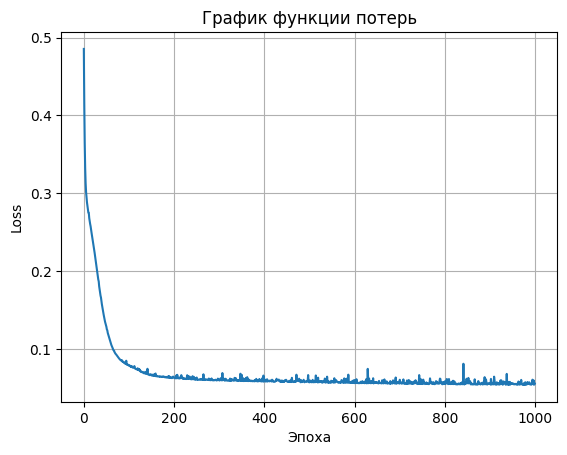

Test accuracy: 98.00%


In [4]:
nn = NeuralNetwork([2, 10, 5, 1], learning_rate=0.05, activation='relu')
losses = nn.fit(X_train, y_train, epochs=1000, batch_size=32)

# График функции потерь
plt.plot(losses)
plt.title("График функции потерь")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid()
plt.show()

# Точность на тесте
y_pred = nn.predict(X_test)
acc = np.mean(y_pred == y_test)
print(f"Test accuracy: {acc * 100:.2f}%")


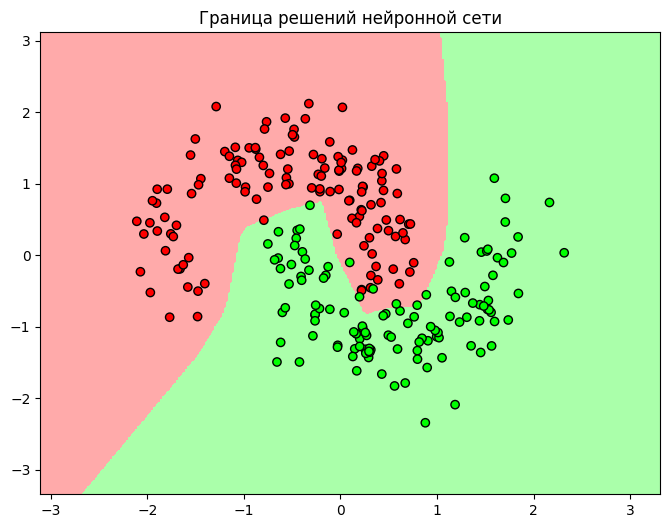

In [5]:
def plot_decision_boundary(model, X, y):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k')
    plt.title("Граница решений нейронной сети")
    plt.show()

plot_decision_boundary(nn, X_test, y_test)
